In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection


In [191]:
# Cube
W = np.array([[0, 0, 200], [50, 0, 200], [50, 50, 200], [0, 50, 200], [
             0, 0, 250], [50, 0, 250], [50, 50, 250], [0, 50, 250], [25, 0, 200], [0,0,225], [50,0,225], [25, 0, 250], [25, 50, 250], [50, 25, 250], [0,25,250], [0,50,225], [0,25,200], [25, 50, 200], [50, 25, 200], [50,50,225]])
print(W.T.shape)
C = np.array([[0, 0, 200], [50, 0, 200], [50, 50, 200], [0, 50, 200], [
             0, 0, 250], [50, 0, 250], [50, 50, 250], [0, 50, 250]])
             
princPtn = np.array([256, 256]) # Principal point
p = np.array([200, 200]) # Focal point
s = 0 # Skew
t = np.radians(35) #Theta (Rotation angle)
d = np.array([200, 0, 0]) # Translation vector

def sin(x): return np.sin(x)
def cos(x): return np.cos(x)


Int = np.array([[p[0], s, princPtn[0], 0], [
    0, p[1], princPtn[1], 0], [0, 0, 1, 0]]) # Intrinsic parameters
O = np.array([[cos(t), 0, -sin(t)], [0, 1, 0], # Rotation matrix
              [sin(t), 0, cos(t)], [0, 0, 0]])
T = np.array([[d[0]], [d[1]], [d[2]], [1]]) #Translation matrix

#Plotting function
def plotProj(proj, title='2D proj'):
    proj = np.hstack((proj, np.zeros((proj.shape[0], 1))))
    print(proj.shape)

    x_max = np.amax(proj[:, 0])
    x_min = np.amin(proj[:, 0])

    y_max = np.amax(proj[:, 1])
    y_min = np.amin(proj[:, 1])

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter3D(proj[:, 0], proj[:, 1], proj[:, 2])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    padding = 25
    # ax.set_xlim(400, 800)
    # ax.set_xlim(200, 500)
    ax.set_xlim(x_min-padding, x_max+padding)
    ax.set_ylim(y_min-padding, y_max+padding)
    # ax.set_xlim(-1, 1)
    # ax.set_ylim(-1, 1)
    verts = [[proj[0], proj[1], proj[2], proj[3]], [proj[4], proj[5], proj[6], proj[7]], [
        proj[0], proj[1], proj[5], proj[4]], [proj[3], proj[2], proj[6], proj[7]]]
    #[X[1],X[2],X[6],X[5]], [X[1],X[2],X[5],X[7]]]

    # plot sides
    ax.add_collection3d(Poly3DCollection(verts, facecolors='w',linewidths=1, edgecolors='k', alpha=.25))
    ax.set_title(title)
    ax.view_init(90, 90)


(3, 20)


Ground truth projection

(20, 3)


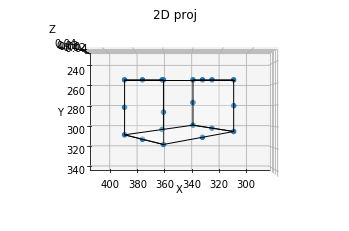

In [199]:
#Pinhole model
def pinHole(W, A, O, T):
    motionMat = np.hstack((O, T))
    X = np.zeros((W.shape[0], W.shape[1]))
    i = 0
    for w in W:
        w_ = np.vstack((np.reshape(w, (3, 1)), [1]))
        x_ = A @ motionMat @ w_
        x_ = x_/x_[2] 
        X[i] = x_.T
        i += 1
    return X
    # return X[:2].reshape((2))

X = pinHole(W, Int, O, T)
# print(X)
plotProj(X[:, :2])




Estimating extrinsic parameters

In [201]:
X_ = np.linalg.inv(Int[:, :3]) @ X.T # Normalized image coordinates

def makeAmatrix(W, X_):
    A = np.zeros((W.shape[0]*2, 12))
    i = 0
    for x_, w in zip(X_, W):
        A[i] = np.array([w[0], w[1], w[2], 1, 0, 0, 0, 0, -w[0]
                         * x_[0], -w[1]*x_[0], -w[2]*x_[0], -x_[0]])
        A[i+1] = np.array([0, 0, 0, 0, w[0], w[1], w[2], 1, -w[0]
                         * x_[1], -w[1]*x_[1], -w[2]*x_[1], -x_[1]])
        i+= 2
    return A


A = makeAmatrix(W, X_.T) #A matrix of eq 14.30

#Perform SVD
u, s, vh = np.linalg.svd(A)

V = vh.T
b = V[:, -1] #Take last column as explained in the book

Om = np.array([[b[0], b[1], b[2]],
               [b[4], b[5], b[6]],
               [b[8], b[9], b[10]]])

tau = np.array([b[3], b[7], b[11]])

u, s, vh = np.linalg.svd(Om)
Om_ = u @ vh #Scaled rotation matrix

tau_ = 1/9*np.sum(Om_/Om)*tau #tau hat from eq 14.31

Om_ *= -1
tau_ *= -1

rot = np.array([[cos(t), 0, -sin(t)], [0, 1, 0],  # Original Rotation matrix
              [sin(t), 0, cos(t)]])

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
print(f'True rotation:\n {rot}')
print(f'Estimated rotation:\n {Om_}')
print(f'True translation:\n {d}')
print(f'Estimated translation:\n {tau_}')


True rotation:
 [[0.819 0.000 -0.574]
 [0.000 1.000 0.000]
 [0.574 0.000 0.819]]
Estimated rotation:
 [[0.819 -0.000 -0.574]
 [0.000 1.000 -0.000]
 [0.574 0.000 0.819]]
True translation:
 [200   0   0]
Estimated translation:
 [198.105 0.000 -0.000]


Projecting estimated image coordinates

In [203]:
O_ = np.vstack((Om_, np.array([0, 0, 0])))  # Estimated Rotation matrix
T_ = np.array([[tau_[0]], [tau_[1]], [tau_[2]], [1]])  # Estimated Translation matrix

X_ = pinHole(W, Int, O_, T_)



Comparison plots

No handles with labels found to put in legend.


(20, 3)


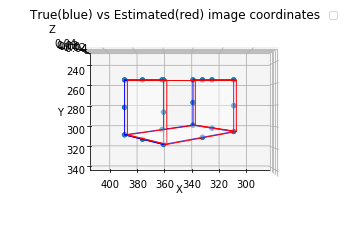

In [211]:
# plotReproj(X[:,:2], X_[:, :2])
# plotProj(X[:, :2], 'True image coordinates')
# plt.show()
# plotProj(X_[:, :2], 'Estimated image coordinates')

def plotReProj(proj, proj_, title='2D proj'):
    proj = np.hstack((proj, np.zeros((proj.shape[0], 1))))
    print(proj.shape)

    proj_ = np.hstack((proj_, np.zeros((proj_.shape[0], 1))))

    x_max = np.amax(proj[:, 0])
    x_min = np.amin(proj[:, 0])

    y_max = np.amax(proj[:, 1])
    y_min = np.amin(proj[:, 1])

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter3D(proj[:, 0], proj[:, 1], proj[:, 2])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    padding = 25
    # ax.set_xlim(400, 800)
    # ax.set_xlim(200, 500)
    ax.set_xlim(x_min-padding, x_max+padding)
    ax.set_ylim(y_min-padding, y_max+padding)
    # ax.set_xlim(-1, 1)
    # ax.set_ylim(-1, 1)
    verts = [[proj[0], proj[1], proj[2], proj[3]], [proj[4], proj[5], proj[6], proj[7]], [
        proj[0], proj[1], proj[5], proj[4]], [proj[3], proj[2], proj[6], proj[7]]]

    verts_ = [[proj_[0], proj_[1], proj_[2], proj_[3]], [proj_[4], proj_[5], proj_[6], proj_[7]], [
        proj_[0], proj_[1], proj_[5], proj_[4]], [proj_[3], proj_[2], proj_[6], proj_[7]]]
    #[X[1],X[2],X[6],X[5]], [X[1],X[2],X[5],X[7]]]

    # plot sides
    ax.add_collection3d(Poly3DCollection(
        verts, facecolors='w', linewidths=1, edgecolors='b', alpha=.25))
    
    ax.add_collection3d(Poly3DCollection(
        verts_, facecolors='w', linewidths=1, edgecolors='r', alpha=.25))
    ax.set_title(title)
    ax.legend()
    # ax.legend(verts, 'Ground Truth')
    # ax.legend(verts_, 'Estimation')
    ax.view_init(90, 90)


plotReProj(X[:, :2], X_[:, :2], 'True(blue) vs Estimated(red) image coordinates')

# def plotProj(proj, title='2D proj'):
#     proj = np.hstack((proj, np.zeros((proj.shape[0], 1))))
#     print(proj.shape)

#     x_max = np.amax(proj[:, 0])
#     x_min = np.amin(proj[:, 0])

#     y_max = np.amax(proj[:, 1])
#     y_min = np.amin(proj[:, 1])

#     fig = plt.figure()
#     ax = fig.add_subplot(111, projection='3d')

#     ax.scatter3D(proj[:, 0], proj[:, 1], proj[:, 2])
#     ax.set_xlabel('X')
#     ax.set_ylabel('Y')
#     ax.set_zlabel('Z')

#     padding = 25
#     # ax.set_xlim(400, 800)
#     # ax.set_xlim(200, 500)
#     ax.set_xlim(x_min-padding, x_max+padding)
#     ax.set_ylim(y_min-padding, y_max+padding)
#     # ax.set_xlim(-1, 1)
#     # ax.set_ylim(-1, 1)
#     verts = [[proj[0], proj[1], proj[2], proj[3]], [proj[4], proj[5], proj[6], proj[7]], [
#         proj[0], proj[1], proj[5], proj[4]], [proj[3], proj[2], proj[6], proj[7]]]
#     #[X[1],X[2],X[6],X[5]], [X[1],X[2],X[5],X[7]]]

#     # plot sides
#     ax.add_collection3d(Poly3DCollection(
#         verts, facecolors='w', linewidths=1, edgecolors='k', alpha=.25))
#     ax.set_title(title)
#     ax.view_init(90, 90)


